In [1]:
import numpy as np
import pandas as pd
import json
import os
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal, HeUniform, HeNormal, Orthogonal
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
df = pd.read_csv("dataset/fashion.csv")
df.to_string(index=False)
df.head(10)

id  gender type_of_clothing  color  season   usage  \
0   1  Female          Tshirts  Black  Summer  Casual   
1   2  Female          Tshirts  Black   Rainy  Casual   
2   3  Female          Tshirts  Black  Summer  Casual   
3   4  Female          Tshirts  White  Summer  Casual   
4   5  Female          Tshirts  White  Summer  Casual   
5   6  Female          Tshirts  White   Rainy  Casual   
6   7  Female          Tshirts   Blue   Rainy  Casual   
7   8  Female          Tshirts   Blue  Summer  Casual   
8   9  Female          Tshirts   Blue  Summer  Sports   
9  10  Female          Tshirts  Brown  Summer  Casual   

             product_display_name  
0       Nope Women Black T-Shirts  
1  Knitwear Women Black T-Shirts   
2  Black Butterfly Women T-Shirts  
3      Cherry White Pink T-Shirts  
4         Cute Dog Women T-Shirts  
5  Knitwear Women White T-Shirts   
6              Blue Sweater Ocean  
7     Croptop Women Blue T-Shirts  
8      Sports Women Blue T-Shirts  
9  Off-White Women Brown T-Shirts

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    310 non-null    int64 
 1   gender                310 non-null    object
 2   type_of_clothing      310 non-null    object
 3   color                 310 non-null    object
 4   season                310 non-null    object
 5   usage                 310 non-null    object
 6   product_display_name  310 non-null    object
dtypes: int64(1), object(6)
memory usage: 17.1+ KB


In [4]:
gender_counts = df['gender'].value_counts()
clothing_counts = df['type_of_clothing'].value_counts()
color_counts = df['color'].value_counts()
season_counts = df['season'].value_counts()
usage_counts = df['usage'].value_counts()
print(gender_counts)
print(clothing_counts)
print(color_counts)
print(season_counts)
print(usage_counts)

gender
Female    124
Male      114
Unisex     72
Name: count, dtype: int64
type_of_clothing
Tshirts    155
Shirts     155
Name: count, dtype: int64
color
Blue     64
White    60
Black    52
Brown    49
Grey     44
Red      41
Name: count, dtype: int64
season
Summer    200
Rainy     110
Name: count, dtype: int64
usage
Casual    121
Sports     65
Formal     63
Ethnic     61
Name: count, dtype: int64


In [5]:
# Load user data from user.json file
with open('dataset/user.json', 'r') as f:
    user_data = json.load(f)

# Ubah data JSON menjadi string
user_data_string = json.dumps(user_data)

user_df = pd.DataFrame(user_data)
user_df.head()

id    gender   type_of_clothing                 color           season  \
0   1    [Male]          [Tshirts]         [Blue, Black]  [Summer, Rainy]   
1   2  [Female]           [Shirts]          [White, Red]          [Rainy]   
2   3  [Unisex]  [Tshirts, Shirts]  [Grey, Black, Brown]          [Rainy]   
3   4    [Male]          [Tshirts]                [Blue]         [Summer]   
4   5  [Female]  [Tshirts, Shirts]  [Grey, Black, White]  [Summer, Rainy]   

              usage  
0          [Casual]  
1          [Formal]  
2  [Sports, Casual]  
3  [Ethnic, Formal]  
4          [Casual]

In [6]:
# Ensure columns are lists
for col in ['gender', 'type_of_clothing', 'color', 'season', 'usage']:
    df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [x])
    user_df[col] = user_df[col].apply(lambda x: x if isinstance(x, list) else [x])

In [7]:
# Combine unique values from both datasets
all_genders = set(df['gender'].explode()).union(set(user_df['gender'].explode()))
all_clothings = set(df['type_of_clothing'].explode()).union(set(user_df['type_of_clothing'].explode()))
all_colors = set(df['color'].explode()).union(set(user_df['color'].explode()))
all_seasons = set(df['season'].explode()).union(set(user_df['season'].explode()))
all_usages = set(df['usage'].explode()).union(set(user_df['usage'].explode()))

In [8]:
# Fit MultiLabelBinarizer on combined unique values
mlb_gender = MultiLabelBinarizer(classes=list(all_genders))
mlb_clothing = MultiLabelBinarizer(classes=list(all_clothings))
mlb_color = MultiLabelBinarizer(classes=list(all_colors))
mlb_season = MultiLabelBinarizer(classes=list(all_seasons))
mlb_usage = MultiLabelBinarizer(classes=list(all_usages))

# Transform the clothing data
gender_encoded = mlb_gender.fit_transform(df['gender'])
clothing_encoded = mlb_clothing.fit_transform(df['type_of_clothing'])
color_encoded = mlb_color.fit_transform(df['color'])
season_encoded = mlb_season.fit_transform(df['season'])
usage_encoded = mlb_usage.fit_transform(df['usage'])

# Concatenate all encoded features
df['features'] = [
    np.concatenate([g, c, col, s, u]) 
    for g, c, col, s, u in zip(gender_encoded, clothing_encoded, color_encoded, season_encoded, usage_encoded)
]

# Transform the user data
user_gender_encoded = mlb_gender.transform(user_df['gender'])
user_clothing_encoded = mlb_clothing.transform(user_df['type_of_clothing'])
user_color_encoded = mlb_color.transform(user_df['color'])
user_season_encoded = mlb_season.transform(user_df['season'])
user_usage_encoded = mlb_usage.transform(user_df['usage'])

# Concatenate all encoded features for user data
user_df['features'] = [
    np.concatenate([g, c, col, s, u]) 
    for g, c, col, s, u in zip(user_gender_encoded, user_clothing_encoded, user_color_encoded, user_season_encoded, user_usage_encoded)
]

# Display the encoded features for user data
print(user_df[['features']].head())

                                            features
0  [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, ...
1  [0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, ...
2  [1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, ...
3  [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, ...
4  [0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, ...


In [39]:
train_data = []

for user in user_df.itertuples():
    user_vector = np.concatenate([
        mlb_gender.transform([user.gender])[0],
        mlb_clothing.transform([user.type_of_clothing])[0],
        mlb_color.transform([user.color])[0],
        mlb_season.transform([user.season])[0],
        mlb_usage.transform([user.usage])[0]
    ])
    
    for _, row in df.iterrows():
        item_vector = row['features']
        label = 0
        if set(user.gender) & set(row['gender']):
            if set(user.type_of_clothing) & set(row['type_of_clothing']):
                if set(user.color) & set(row['color']):
                    if set(user.season) & set(row['season']):
                        if set(user.usage) & set(row['usage']):
                            label = 1
        train_data.append((np.concatenate([user_vector, item_vector]), label))

# Convert to numpy array for training
X, y = zip(*train_data)
X = np.array(X)
y = np.array(y)

In [40]:
# Split the data into training and testing sets
train_x, train_y = zip(*train_data)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.3)

train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)
print("Dimensi train_x:", train_x.shape)
print("Dimensi train_y:", train_y.shape)
print("Dimensi test_x:", test_x.shape)
print("Dimensi test_y:", test_y.shape)

Dimensi train_x: (2170, 34)
Dimensi train_y: (2170,)
Dimensi test_x: (930, 34)
Dimensi test_y: (930,)


In [41]:
def create_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Dense(256, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.0001)))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

input_shape = train_x.shape[1]
num_classes = 2

model = create_model(input_shape, num_classes)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               8960      
                                                                 
 batch_normalization_9 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 512)               131584    
                                                                 
 batch_normalization_10 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 512)              

In [42]:
#Convert labels to categorical
train_y = tf.keras.utils.to_categorical(train_y, num_classes)
test_y = tf.keras.utils.to_categorical(test_y, num_classes)
print("Dimensi train_x:", train_x.shape)
print("Dimensi train_y:", train_y.shape)
print("Dimensi test_x:", test_x.shape)
print("Dimensi test_y:", test_y.shape)

Dimensi train_x: (2170, 34)
Dimensi train_y: (2170, 2)
Dimensi test_x: (930, 34)
Dimensi test_y: (930, 2)


In [43]:
checkpoint_dir = 'model/'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, 'best_model_cbf.keras')

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max',verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True,verbose=1)

batch_size = 32
epochs = 50

history = model.fit(train_x, train_y, batch_size=batch_size,
                    epochs=epochs, validation_data=(test_x, test_y),
                    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/50
62/68 [==========================>...] - ETA: 0s - loss: 0.8984 - accuracy: 0.5449
Epoch 1: val_accuracy improved from -inf to 0.95806, saving model to model\best_model_cbf.keras
68/68 [==============================] - 3s 15ms/step - loss: 0.8925 - accuracy: 0.5488 - val_loss: 0.7235 - val_accuracy: 0.9581
Epoch 2/50
62/68 [==========================>...] - ETA: 0s - loss: 0.7796 - accuracy: 0.6396
Epoch 2: val_accuracy improved from 0.95806 to 0.97634, saving model to model\best_model_cbf.keras
68/68 [==============================] - 1s 12ms/step - loss: 0.7783 - accuracy: 0.6424 - val_loss: 0.6458 - val_accuracy: 0.9763
Epoch 3/50
64/68 [===========================>..] - ETA: 0s - loss: 0.7093 - accuracy: 0.7109
Epoch 3: val_accuracy did not improve from 0.97634
68/68 [==============================] - 1s 11ms/step - loss: 0.7081 - accuracy: 0.7143 - val_loss: 0.5863 - val_accuracy: 0.9731
Epoch 4/50
65/68 [===========================>..] - ETA: 0s - loss: 0.6540 - accur

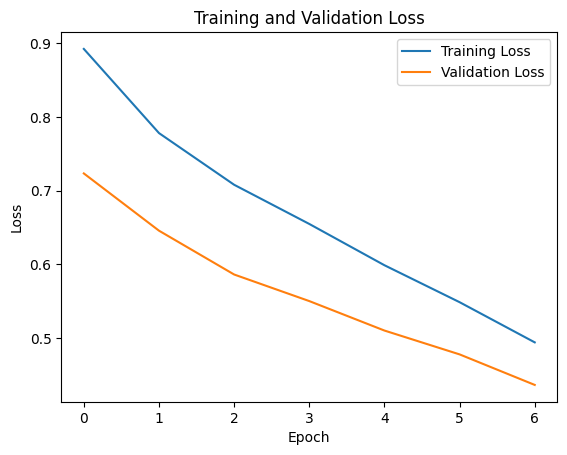

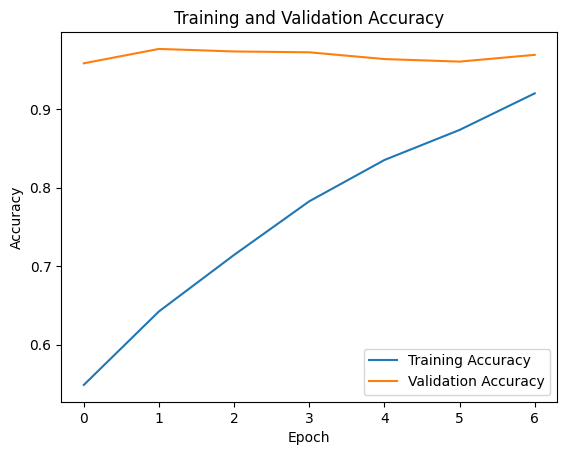

In [44]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 33ms/step
Nike Men Printed Black Tshirts: 0.7674


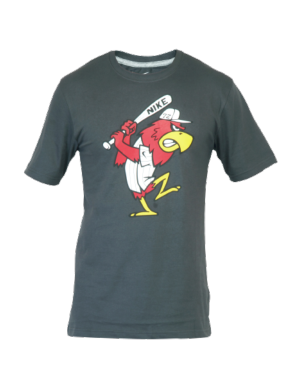

Nike Men As Ad Badge Black T-Shirts: 0.7674


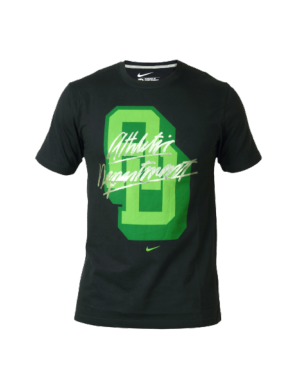

Blue rainy clothes: 0.7537


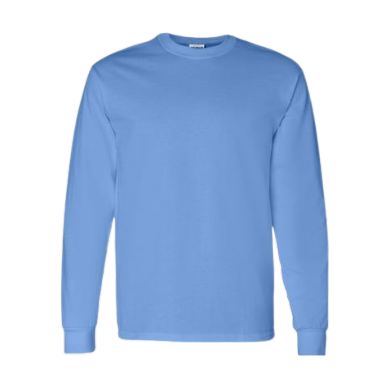

Long Sleeve blue shirt: 0.7537


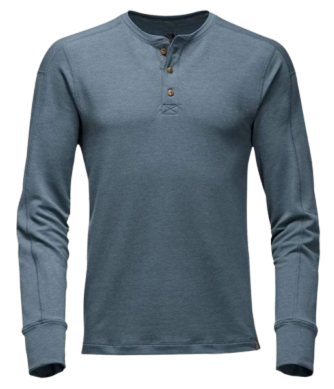

blue jacket for rainy season: 0.7537


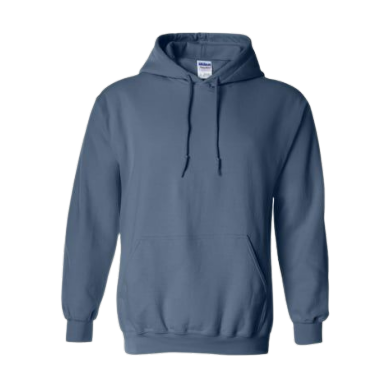

black plain jacket: 0.7306


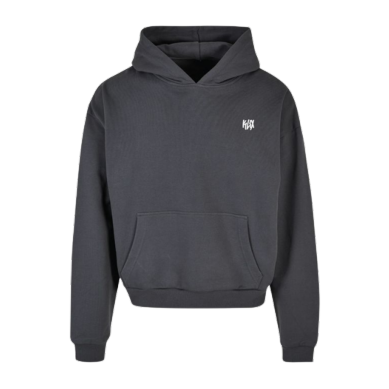

In [45]:
def get_recommendations(user_input, model, item_data, mlb_gender, mlb_clothing, mlb_color, mlb_season, mlb_usage, num_recommendations=6):
    # Encode user input
    user_vector = np.concatenate([
        mlb_gender.transform([user_input['gender']])[0],
        mlb_clothing.transform([user_input['type_of_clothing']])[0],
        mlb_color.transform([user_input['color']])[0],
        mlb_season.transform([user_input['season']])[0],
        mlb_usage.transform([user_input['usage']])[0]
    ])

    scores = []
    for _, row in item_data.iterrows():
        item_vector = row['features']
        combined_vector = np.concatenate([user_vector, item_vector]).reshape(1, -1)
        
        # Calculate cosine similarity
        similarity_score = cosine_similarity([user_vector], [item_vector])[0][0]
        
        # Calculate prediction score
        prediction_score = model.predict(combined_vector)[0][0]
        
        # Combine similarity and prediction scores
        final_score = (similarity_score + prediction_score) / 2
        
        scores.append((row['product_display_name'], row['id'], final_score))
    
    scores.sort(key=lambda x: x[2], reverse=True)
    return scores[:num_recommendations]

# Sample user input
user_input = user_data[0]

# Get recommendations
recommendations = get_recommendations(user_input, model, df, mlb_gender, mlb_clothing, mlb_color, mlb_season, mlb_usage)

# Display top 6 recommendations
for item, item_id, score in recommendations:
    print(f"{item}: {score:.4f}")
    # Display image based on product ID
    image_path = f"dataset/fashionimg/{item_id}.png"  # Adjust the path according to your folder structure
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 32ms/step
Formal Suit Women: 0.7026


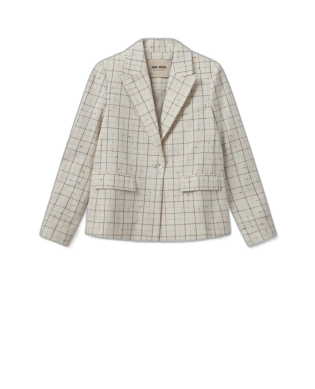

Gucci Shirts For Work: 0.7026


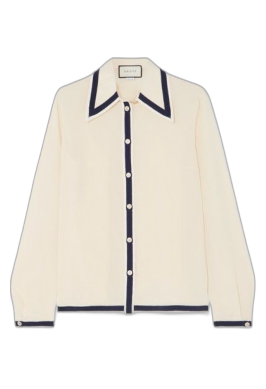

formal shirts women: 0.7026


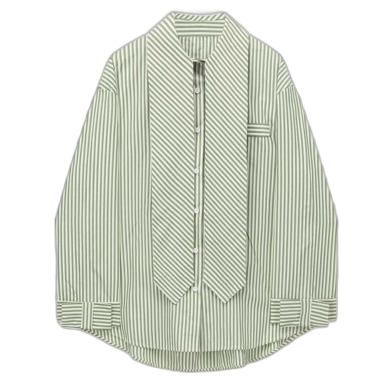

Formal Shirts Unisex: 0.7026


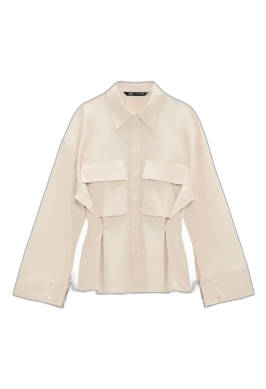

Gucci Coat Formal Edition: 0.6496


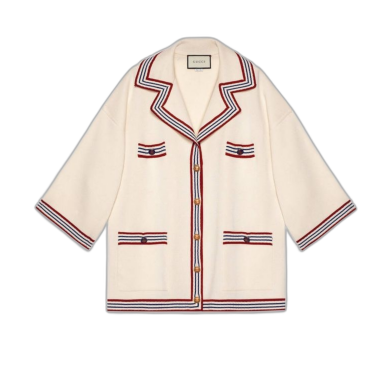

Pink Blazer Women: 0.6377


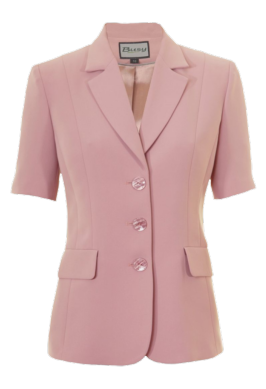

In [46]:
def get_recommendations(user_input, model, item_data, mlb_gender, mlb_clothing, mlb_color, mlb_season, mlb_usage, num_recommendations=6):
    # Encode user input
    user_vector = np.concatenate([
        mlb_gender.transform([user_input['gender']])[0],
        mlb_clothing.transform([user_input['type_of_clothing']])[0],
        mlb_color.transform([user_input['color']])[0],
        mlb_season.transform([user_input['season']])[0],
        mlb_usage.transform([user_input['usage']])[0]
    ])
    
    scores = []
    for _, row in item_data.iterrows():
        item_vector = row['features']
        combined_vector = np.concatenate([user_vector, item_vector]).reshape(1, -1)
        
        # Calculate cosine similarity
        similarity_score = cosine_similarity([user_vector], [item_vector])[0][0]
        
        # Calculate prediction score
        prediction_score = model.predict(combined_vector)[0][0]
        
        # Combine similarity and prediction scores
        final_score = (similarity_score + prediction_score) / 2
        
        scores.append((row['product_display_name'], row['id'], final_score))
    
    scores.sort(key=lambda x: x[2], reverse=True)
    return scores[:num_recommendations]

# Sample user input
user_input = user_data[1]

# Get recommendations
recommendations = get_recommendations(user_input, model, df, mlb_gender, mlb_clothing, mlb_color, mlb_season, mlb_usage)

# Display top 6 recommendations
for item, item_id, score in recommendations:
    print(f"{item}: {score:.4f}")
    # Display image based on product ID
    image_path = f"dataset/fashionimg/{item_id}.png"  # Adjust the path according to your folder structure
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 27ms/step
New Balance Unisex Grey Hoodie: 0.7180


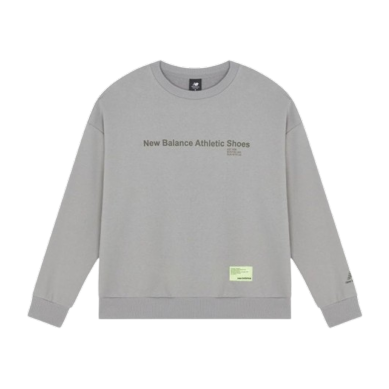

Kids Apparel Unisex: 0.7112


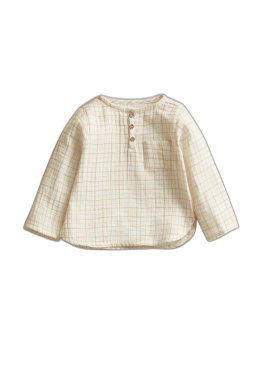

Adidas Unisex Black Sweatshirt: 0.7107


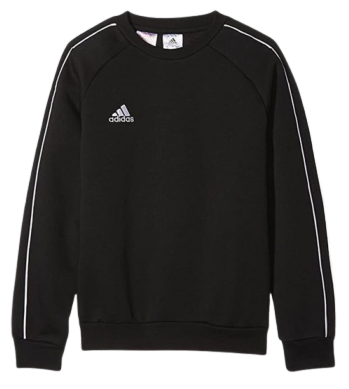

Sweater Unisex: 0.7078


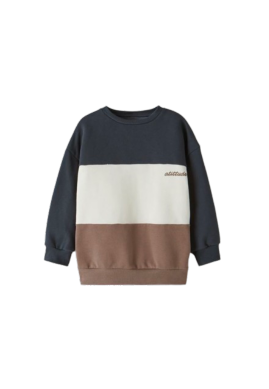

Converse Unisex Brown Long Sleeve: 0.7057


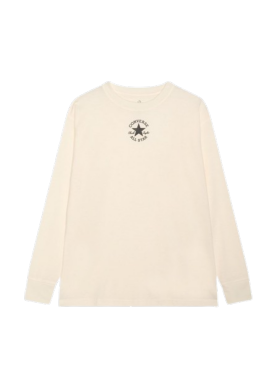

Long-sleeve Polo Unisex: 0.6860


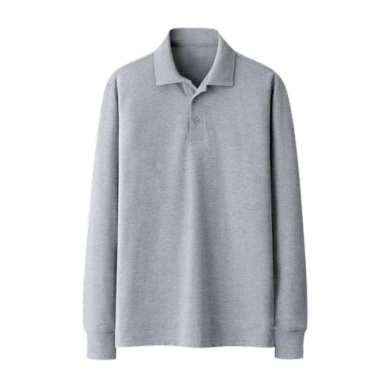

In [47]:
def get_recommendations(user_input, model, item_data, mlb_gender, mlb_clothing, mlb_color, mlb_season, mlb_usage, num_recommendations=6):
    # Encode user input
    user_vector = np.concatenate([
        mlb_gender.transform([user_input['gender']])[0],
        mlb_clothing.transform([user_input['type_of_clothing']])[0],
        mlb_color.transform([user_input['color']])[0],
        mlb_season.transform([user_input['season']])[0],
        mlb_usage.transform([user_input['usage']])[0]
    ])
    
    scores = []
    for _, row in item_data.iterrows():
        item_vector = row['features']
        combined_vector = np.concatenate([user_vector, item_vector]).reshape(1, -1)
        
        # Calculate cosine similarity
        similarity_score = cosine_similarity([user_vector], [item_vector])[0][0]
        
        # Calculate prediction score
        prediction_score = model.predict(combined_vector)[0][0]
        
        # Combine similarity and prediction scores
        final_score = (similarity_score + prediction_score) / 2
        
        scores.append((row['product_display_name'], row['id'], final_score))
    
    scores.sort(key=lambda x: x[2], reverse=True)
    return scores[:num_recommendations]

# Sample user input
user_input = user_data[2]

# Get recommendations
recommendations = get_recommendations(user_input, model, df, mlb_gender, mlb_clothing, mlb_color, mlb_season, mlb_usage)

# Display top 6 recommendations
for item, item_id, score in recommendations:
    print(f"{item}: {score:.4f}")
    # Display image based on product ID
    image_path = f"dataset/fashionimg/{item_id}.png"  # Adjust the path according to your folder structure
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 32ms/step
Nike Men's As Icon Blue T-shirt: 0.7498


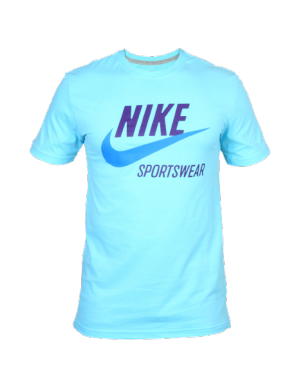

Blue male batik: 0.7396


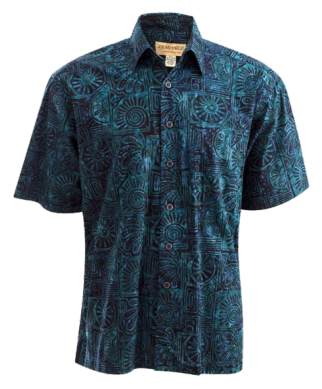

blue basic men's batic: 0.7396


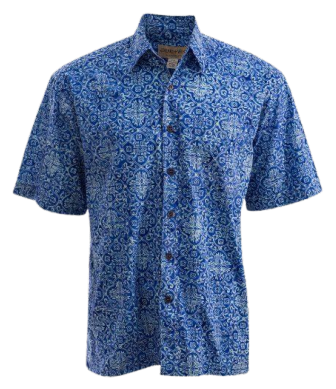

Ethnic Modern Men: 0.7396


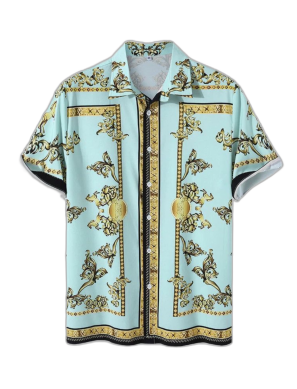

Blue Ethnic Outer Men: 0.7301


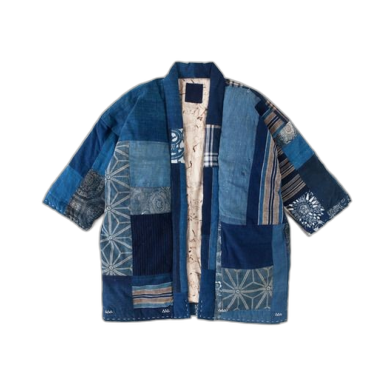

Denim Ethnic Outer Men: 0.7301


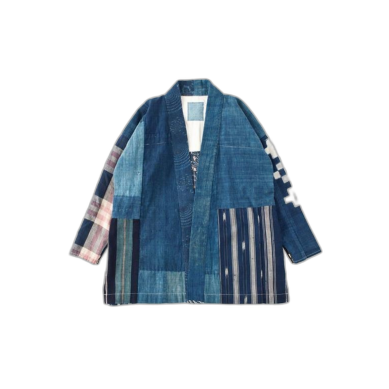

In [48]:
def get_recommendations(user_input, model, item_data, mlb_gender, mlb_clothing, mlb_color, mlb_season, mlb_usage, num_recommendations=6):
    # Encode user input
    user_vector = np.concatenate([
        mlb_gender.transform([user_input['gender']])[0],
        mlb_clothing.transform([user_input['type_of_clothing']])[0],
        mlb_color.transform([user_input['color']])[0],
        mlb_season.transform([user_input['season']])[0],
        mlb_usage.transform([user_input['usage']])[0]
    ])
    
    scores = []
    for _, row in item_data.iterrows():
        item_vector = row['features']
        combined_vector = np.concatenate([user_vector, item_vector]).reshape(1, -1)
        
        # Calculate cosine similarity
        similarity_score = cosine_similarity([user_vector], [item_vector])[0][0]
        
        # Calculate prediction score
        prediction_score = model.predict(combined_vector)[0][0]
        
        # Combine similarity and prediction scores
        final_score = (similarity_score + prediction_score) / 2
        
        scores.append((row['product_display_name'], row['id'], final_score))
    
    scores.sort(key=lambda x: x[2], reverse=True)
    return scores[:num_recommendations]

# Sample user input
user_input = user_data[3]

# Get recommendations
recommendations = get_recommendations(user_input, model, df, mlb_gender, mlb_clothing, mlb_color, mlb_season, mlb_usage)

# Display top 6 recommendations
for item, item_id, score in recommendations:
    print(f"{item}: {score:.4f}")
    # Display image based on product ID
    image_path = f"dataset/fashionimg/{item_id}.png"  # Adjust the path according to your folder structure
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 47ms/step
Louis Heart Sweatshirt: 0.6448


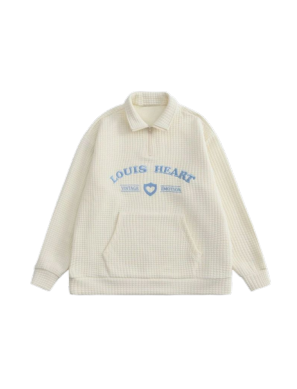

Femella Women White Printed Shirt: 0.6448


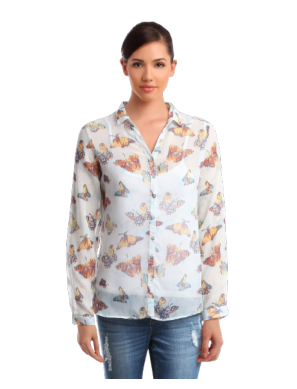

Long Sleeve Shirts Men: 0.6375


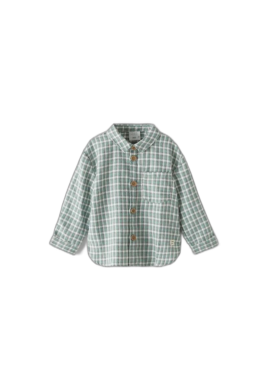

Warmth and Whimsy Wardrobe: 0.6375


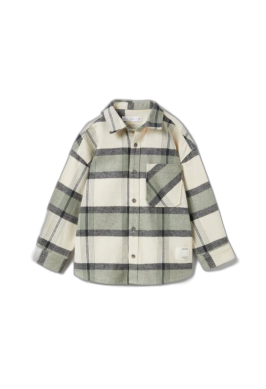

White Polo Jacket Unisex: 0.6338


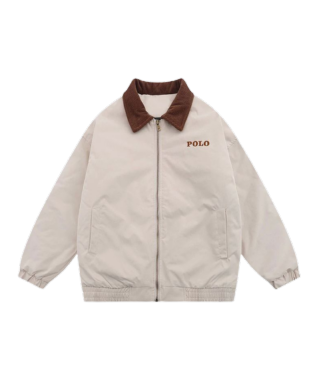

Long-sleeve Polo Unisex: 0.6307


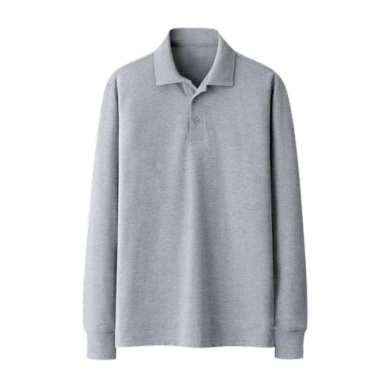

In [49]:
def get_recommendations(user_input, model, item_data, mlb_gender, mlb_clothing, mlb_color, mlb_season, mlb_usage, num_recommendations=6):
    # Encode user input
    user_vector = np.concatenate([
        mlb_gender.transform([user_input['gender']])[0],
        mlb_clothing.transform([user_input['type_of_clothing']])[0],
        mlb_color.transform([user_input['color']])[0],
        mlb_season.transform([user_input['season']])[0],
        mlb_usage.transform([user_input['usage']])[0]
    ])
    
    scores = []
    for _, row in item_data.iterrows():
        item_vector = row['features']
        combined_vector = np.concatenate([user_vector, item_vector]).reshape(1, -1)
        
        # Calculate cosine similarity
        similarity_score = cosine_similarity([user_vector], [item_vector])[0][0]
        
        # Calculate prediction score
        prediction_score = model.predict(combined_vector)[0][0]
        
        # Combine similarity and prediction scores
        final_score = (similarity_score + prediction_score) / 2
        
        scores.append((row['product_display_name'], row['id'], final_score))
    
    scores.sort(key=lambda x: x[2], reverse=True)
    return scores[:num_recommendations]

# Sample user input
user_input = user_data[4]

# Get recommendations
recommendations = get_recommendations(user_input, model, df, mlb_gender, mlb_clothing, mlb_color, mlb_season, mlb_usage)

# Display top 6 recommendations
for item, item_id, score in recommendations:
    print(f"{item}: {score:.4f}")
    # Display image based on product ID
    image_path = f"dataset/fashionimg/{item_id}.png"  # Adjust the path according to your folder structure
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 34ms/step
blue light formal shirt: 0.8137


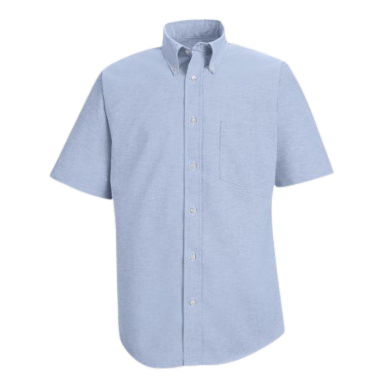

Arrow Men Blue Shirt: 0.8137


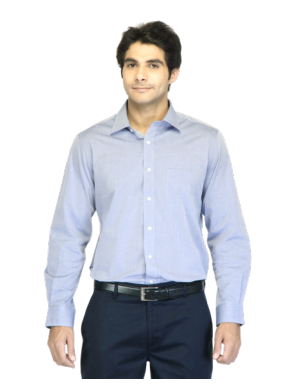

Mark Taylor Men Blue Striped Shirt: 0.8137


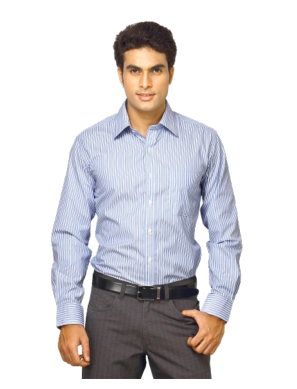

John Miller Men Blue black stripe Black Shirts: 0.7884


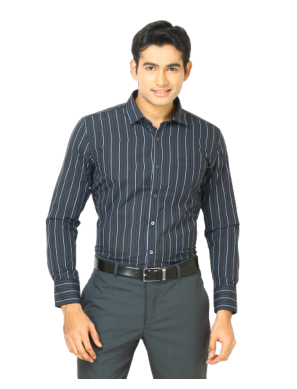

United Colors Of Benetton Men Summer Black Shirts: 0.7884


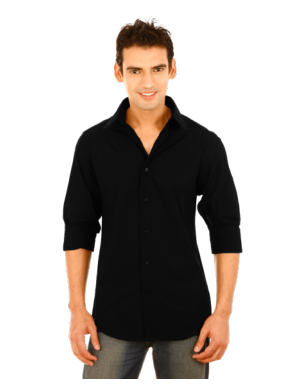

Peter England Men Stripes Black Shirt: 0.7884


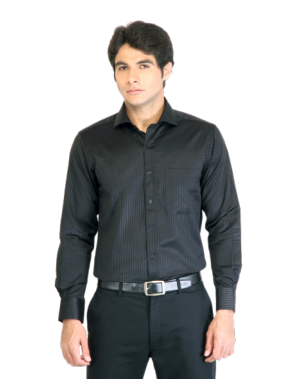

In [50]:
def get_recommendations(user_input, model, item_data, mlb_gender, mlb_clothing, mlb_color, mlb_season, mlb_usage, num_recommendations=6):
    # Encode user input
    user_vector = np.concatenate([
        mlb_gender.transform([user_input['gender']])[0],
        mlb_clothing.transform([user_input['type_of_clothing']])[0],
        mlb_color.transform([user_input['color']])[0],
        mlb_season.transform([user_input['season']])[0],
        mlb_usage.transform([user_input['usage']])[0]
    ])
    
    scores = []
    for _, row in item_data.iterrows():
        item_vector = row['features']
        combined_vector = np.concatenate([user_vector, item_vector]).reshape(1, -1)
        
        # Calculate cosine similarity
        similarity_score = cosine_similarity([user_vector], [item_vector])[0][0]
        
        # Calculate prediction score
        prediction_score = model.predict(combined_vector)[0][0]
        
        # Combine similarity and prediction scores
        final_score = (similarity_score + prediction_score) / 2
        
        scores.append((row['product_display_name'], row['id'], final_score))
    
    scores.sort(key=lambda x: x[2], reverse=True)
    return scores[:num_recommendations]

# Sample user input
with open('dataset/user_tes.json', 'r') as f:
    user_tes = json.load(f)
user_input = user_tes[0]

# Get recommendations
recommendations = get_recommendations(user_input, model, df, mlb_gender, mlb_clothing, mlb_color, mlb_season, mlb_usage)

# Display top 6 recommendations
for item, item_id, score in recommendations:
    print(f"{item}: {score:.4f}")
    # Display image based on product ID
    image_path = f"dataset/fashionimg/{item_id}.png"  # Adjust the path according to your folder structure
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [51]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model('model/best_model_cbf.keras')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('best_model_cbf.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite format.")

INFO:tensorflow:Assets written to: C:\Users\putri\AppData\Local\Temp\tmp5cvmrjpn\assets


INFO:tensorflow:Assets written to: C:\Users\putri\AppData\Local\Temp\tmp5cvmrjpn\assets


Model successfully converted to TensorFlow Lite format.
